# Attention in a family of Boltzmann machines emerging from modern Hopfield networks

This notebook provides a Python implementation of the *attentional Boltzmann machine* (AttnBM) presented in the paper "Attention in a family of Boltzmann machines emerging from modern Hopfield networks," [arXiv:2212.04692](https://arxiv.org/abs/2212.04692).

We give a simple numerical demonstration in PyTorch. The results of Figures 1 & 3 in the paper can be reproduced by the following three steps:

1. Pre-processing the data (ZCA whitening)
1. Define and train AttnBM
1. Image reconstruction and visualization of the receptive fields

In this notebook we consider only the case of P=200 for the MNIST dataset, while the cases of P=50000 and the van Hateren natural images can easily be obtained by slightly modifying the Step 1 below. For more details, see Sec. 3.5 of the paper.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn.parameter import Parameter
from torch.utils.data import TensorDataset, DataLoader

import time
from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def check_images(x, title=None, size=28):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(x[i].reshape(size, size), cmap='gray')
        plt.title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Step 1: Pre-processing the data (ZCA whitening)

In [ ]:
def zca_whitening(X):
    """
        Input: X: M x N matrix; M observations, N variables
        Output: ZCA whitenend X: (M, N) 
    """
    sigma = np.cov(X, bias=True)  # M x M covariance matrix: (X-mu)*(X-mu)^T / M
    U, S, V = np.linalg.svd(sigma)
    
    epsilon = 1e-12  # whitening constant: prevents division by zero
    S2 = np.diag(1.0 / np.sqrt(S + epsilon))
    ZCAMatrix = U @ S2 @ U.T
    return ZCAMatrix @ X

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)


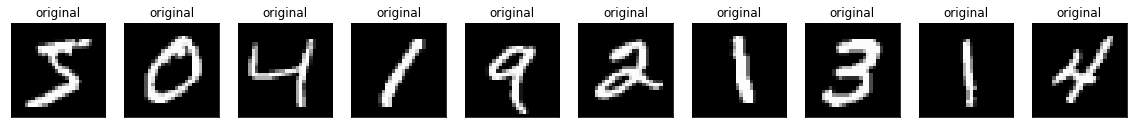

(200, 784)


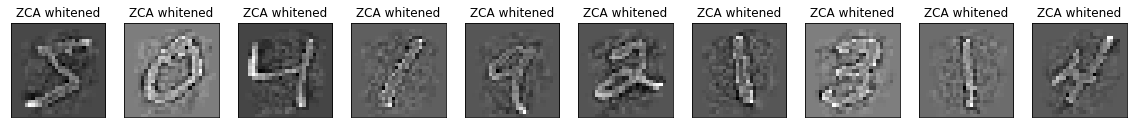

In [ ]:
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

x_train = x_train.reshape(len(x_train), -1)  # (60000, 784)
x_train = x_train.astype('float32')
x_train /= 255
print(x_train.shape)
check_images(x_train, title='original')


n_sample = 200
x_zca = zca_whitening(x_train[:n_sample])
x_zca = x_zca / np.std(x_zca)
print(x_zca.shape)
check_images(x_zca, title='ZCA whitened')

In [ ]:
# Prepare for training in PyTorch
X_train = torch.Tensor(x_zca).to(device)
Y_train = torch.Tensor(np.empty(x_zca.shape[0])).to(device)

b_size = 5
ds_train = TensorDataset(X_train, Y_train)
loader_train = DataLoader(ds_train, batch_size=b_size, shuffle=True)

### or load a pre-processed data

(200, 784)


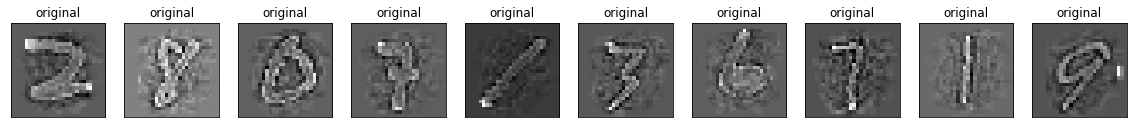

In [ ]:
import scipy.io
path = '/path/to/Zdata_N200.mat'
mat = scipy.io.loadmat(path)

data_mnist = mat['images'].T
x_train = data_mnist / np.std(data_mnist)
print(x_train.shape)


# Prepare for training in pytorch
X_train = torch.Tensor(x_train).to(device)
Y_train = torch.Tensor(np.empty(x_train.shape[0])).to(device)

b_size = 5
ds_train = TensorDataset(X_train, Y_train)
loader_train = DataLoader(ds_train, batch_size=b_size, shuffle=True)


check_images(x_train, title='original')

## Step 2: Define and train the model

In [ ]:
# AttnBM impl as a two-layer MLP
class AttnBM(nn.Module):
    """AttnBM in PyTorch
    Attributes:
        Nv : n_visible
        Nh : n_hidden
        w : weight
        b : bias for visibles
        c : bias for hiddens
        bc : turn on/off b & c (bool, default: False)
        lr : learning rate
    """
    def __init__(self, Nv=None, Nh=900,
                 epoch=10, lr=0.01, bc=False, seed=0, device='cpu'):
        super(AttnBM, self).__init__()
        self.Nv = Nv
        self.Nh = Nh
        self.w = Parameter(torch.empty((Nh, Nv), device=device).normal_(mean=0, std=1) / np.sqrt(Nv))
        self.b = Parameter(torch.zeros(1, Nv, device=device))
        self.c = Parameter(torch.zeros(1, Nh, device=device))
        self.epoch = epoch
        self.lr = lr

        self.params = [self.w]
        if bc:
            self.params.extend([self.b, self.c])

        self.optim = optim.SGD(self.params, lr=self.lr)
        self.losses = []
        self.bs = []
        self.cs = []


    # two-layer feedforward MLP: the update rule of the model B, see Eq.13
    def forward(self, v):
        h = F.linear(v, self.w)
        soft = F.softmax(h, dim=-1)
        v_out = F.linear(soft, self.w.T)
        return v, v_out

    # image reconstruction, see Eq.39
    def reconstruct(self, v_o, missing, n_recon=10):
        v_out = torch.empty((n_recon, self.Nv), device=device)
        for i in range(n_recon):
            w_m = self.w * missing[i]
            temp = F.linear(v_o[i], self.w) + 0.5*torch.square(w_m).sum(dim=-1)
            soft = F.softmax(temp, dim=-1)
            v_m  = F.linear(soft, w_m.T)
            v_out[i] = v_o[i] + v_m
        return v_o, v_out

    # display receptive fields
    def get_recep(self, n_recep=6):
        size = int(np.sqrt(self.Nv))
        plt.figure(figsize=(20, 12))
        for i in range(n_recep**2):
            z = self.w[i,:].view(size, size).detach().cpu().numpy()
            plt.subplot(n_recep, n_recep, i + 1)
            plt.imshow(z, cmap='gray')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


    def loss(self, v):
        energy = 0.5*torch.square(v - self.b).sum(dim=-1) - torch.logsumexp(F.linear(v, self.w, self.c), dim=-1)
        logz = torch.logsumexp(0.5*torch.square(self.w).sum(dim=-1) + F.linear(self.b, self.w, self.c), dim=-1) # + 0.5*self.Nv*torch.log(2*PI)
        return energy + logz

    def fit(self, train_loader):
        for epoch in tqdm(range(self.epoch)):
            start = time.time()
            train_loss_epoch = 0

            for data, _ in train_loader:
                train_loss = self.loss(data).mean()
                self.optim.zero_grad()
                train_loss.backward()
                self.optim.step()

                train_loss_epoch += train_loss.item()
            
            temp = train_loss_epoch / len(train_loader.dataset)
            self.losses.append(temp)
            self.bs.append(self.b.norm().item())
            self.cs.append(self.c.norm().item())
            end = time.time()
            if epoch%200==0:
                print(f'Epoch {epoch}, Loss = {temp:.3f}, {end-start:.2f}s')

In [ ]:
img_size  = 28
img_size2 = img_size**2

epoch = 10000
lr = 0.01
bc = False  # can turn on the biases b & c by setting 'True'

model = AttnBM(Nv=img_size2,
            epoch=epoch,
            lr=lr,
            bc=bc,
            device=device)
model.fit(loader_train)

save_path = '/path/to/attnbm_mnist200.pth'
torch.save(model.state_dict(), save_path)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0, Loss = 78.654, 2.74s
Epoch 200, Loss = 46.607, 0.07s
Epoch 400, Loss = 26.876, 0.08s
Epoch 600, Loss = 19.100, 0.14s
Epoch 800, Loss = 16.027, 0.06s
Epoch 1000, Loss = 14.813, 0.07s
Epoch 1200, Loss = 14.334, 0.16s
Epoch 1400, Loss = 14.143, 0.07s
Epoch 1600, Loss = 14.068, 0.09s
Epoch 1800, Loss = 14.038, 0.09s
Epoch 2000, Loss = 14.025, 0.07s
Epoch 2200, Loss = 14.020, 0.09s
Epoch 2400, Loss = 14.018, 0.08s
Epoch 2600, Loss = 14.019, 0.06s
Epoch 2800, Loss = 14.017, 0.06s
Epoch 3000, Loss = 14.017, 0.06s
Epoch 3200, Loss = 14.016, 0.07s
Epoch 3400, Loss = 14.015, 0.08s
Epoch 3600, Loss = 14.017, 0.12s
Epoch 3800, Loss = 14.017, 0.07s
Epoch 4000, Loss = 14.017, 0.07s
Epoch 4200, Loss = 14.016, 0.06s
Epoch 4400, Loss = 14.018, 0.07s
Epoch 4600, Loss = 14.017, 0.07s
Epoch 4800, Loss = 14.016, 0.07s
Epoch 5000, Loss = 14.017, 0.07s
Epoch 5200, Loss = 14.017, 0.07s
Epoch 5400, Loss = 14.017, 0.07s
Epoch 5600, Loss = 14.018, 0.07s
Epoch 5800, Loss = 14.016, 0.06s
Epoch 6000, Loss 

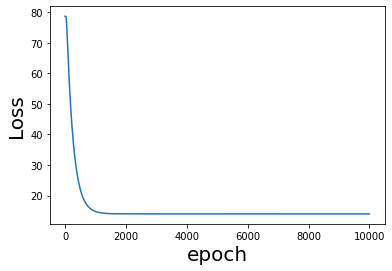

In [ ]:
plt.plot(model.losses) #, marker='o')
plt.xlabel('epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.show()


# if turned b & c on:
#print()
#print(f'|b| at final epoch = {model.b.norm()}')
#print(f'|c| at final epoch = {model.c.norm()}')

#fig = plt.figure(figsize=(12, 4))
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)

#xl = 'epoch'
#yl1 = 'bs'; yl2 = 'cs'

#ax1.set_xlabel(xl)
#ax1.set_ylabel(yl1)
#ax1.set_ylim(-0.2, 10)
#ax1.plot(model.bs)

#ax2.set_xlabel(xl)
#ax2.set_ylabel(yl2)
#ax2.set_ylim(-0.2, 10)
#ax2.plot(model.cs)

#fig.show()

## Step 3: Image reconstruction and visualization of the receptive fields


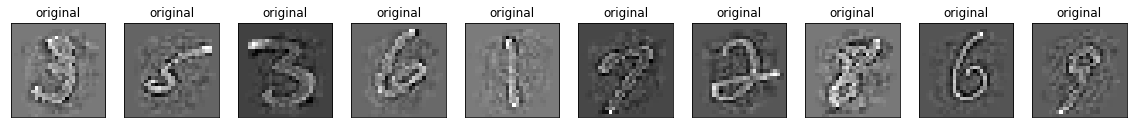

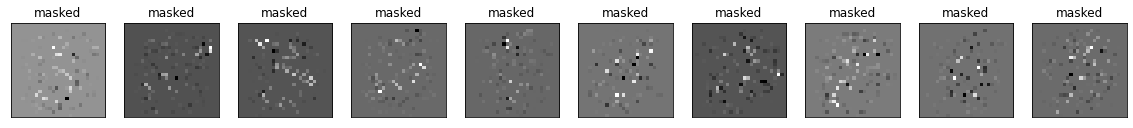

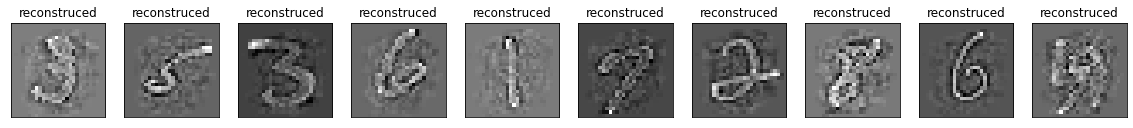

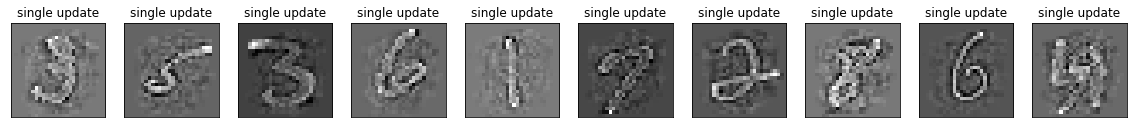


 Receptive fields:


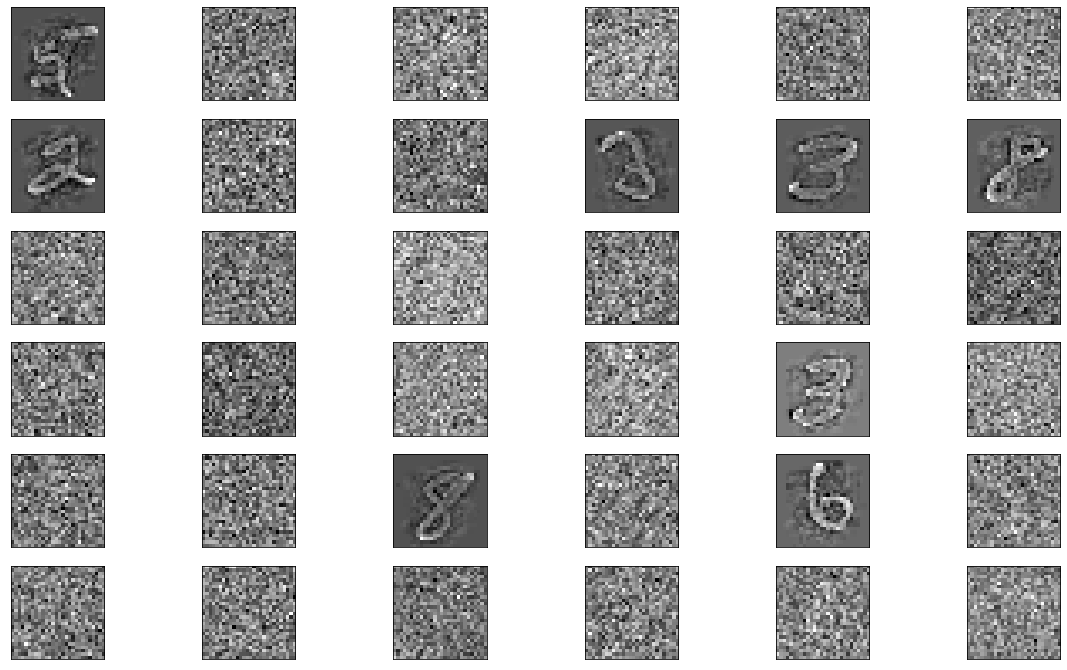

In [ ]:
# load a trained model
load_path = '/path/to/attnbm_mnist200.pth'

img_size  = 28
img_size2 = img_size**2
model = AttnBM(Nv=img_size2,
            device=device)
model.load_state_dict(torch.load(load_path))
model.eval()


n = 10
mask = (np.random.rand(n, img_size2) > 0.2).astype(int)
missing = torch.Tensor(mask).to(device)
observed = torch.Tensor(np.ones([n, img_size2]) - mask).to(device)


k = 1
nk = n*k
v = X_train[nk:nk+10].to(device)
v_o = v * observed


v_mask  = v_o.detach().cpu().numpy()
v_recon = model.reconstruct(v_o, missing, n_recon=n)[1].detach().cpu().numpy()
v_out   = model(v_o)[1].detach().cpu().numpy()


check_images(x_zca[nk:nk+10], 'original')
check_images(v_mask, 'masked')
check_images(v_recon, 'reconstruced')
check_images(v_out, 'single update')


print('\n Receptive fields:')
model.get_recep()

To check the memorized images, let us sort the weight vectors in descending order of their norms:

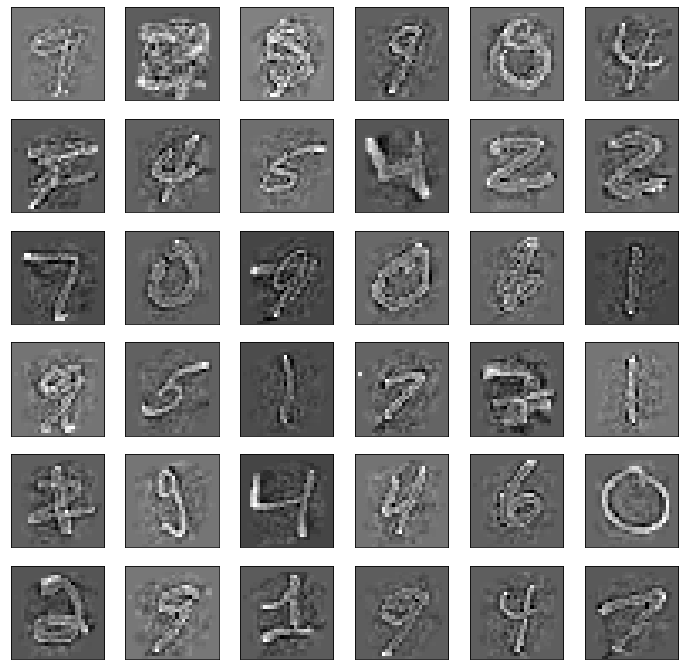

In [ ]:
def vis_recep(net, n_recep=6):
    size = int(np.sqrt(net.Nv))
    plt.figure(figsize=(12, 12))
    sortidxs = np.argsort(np.linalg.norm(net.w.detach().cpu().numpy(), axis=-1))
    for i in range(n_recep**2):
        z = net.w[sortidxs]
        z = z[-(i+1),:].view(size, size).detach().cpu().numpy()
        plt.subplot(n_recep, n_recep, i + 1)
        plt.imshow(z, cmap='gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


vis_recep(model, n_recep=6)